# RBA Selected Tables

Worth reading

*  [Updates to Australia's Financial Aggregates](https://www.rba.gov.au/publications/bulletin/2019/mar/updates-to-australias-financial-aggregates.html)

## Set-Up

In [1]:
# standard library imports
import math
from pathlib import Path


# usual data science imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# local imports
import rba_data_capture
from abs_data_capture import get_abs_meta_and_data, get_fs_constants
from plotting import (
    clear_chart_dir,
    finalise_plot,
    line_plot,
    plot_covid_recovery,
    plot_series_highlighted,
    recalibrate_series,
    set_chart_dir,
)

# display charts in notebook
SHOW = True

### Some useful constants

In [2]:
TODAY = pd.Timestamp("today")
TOMORROW = TODAY + pd.DateOffset(days=1)

# multi-time-period charts
YEARS5_PERIOD_Y = 5  # years
YEARS5_PERIOD_M = 3  # months
YEARS5 = TODAY - pd.DateOffset(years=YEARS5_PERIOD_Y, months=YEARS5_PERIOD_M)

CURRENT_CYCLE = pd.Timestamp("2022-04-01")

V_RECENCY_PERIOD = 370  # days
YEARS1 = TODAY - pd.DateOffset(days=V_RECENCY_PERIOD)

VV_RECENCY_PERIOD = 180  # days
MONTHS6 = TODAY - pd.DateOffset(days=VV_RECENCY_PERIOD)

TEN_YEARS = TODAY - pd.DateOffset(years=10)

# Where to put the charts
CHART_DIR = "./CHARTS/RBA"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)

# plotting stuff
plt.style.use("fivethirtyeight")
SOURCE = "Source: RBA"

### List available data tables - but only if needed

In [3]:
if False:
    print(rba_data_capture.get_data_table_labels())

### Clear cache - but only if necessary

In [4]:
if False:
    rba_data_capture.clear_cache()

### Utility functions

In [5]:
def print_last_date(df: pd.DataFrame) -> None:
    print("Last date", df.index[-1])


def print_last_row(df: pd.DataFrame) -> None:
    print("Last date", df.loc[df.index[-1]])

## Monetary Policy - Official Cash Rate (A2)

### Line charts of Official Cash Rate - different time horizons

In [6]:
# get the data
a2 = rba_data_capture.get_data("Monetary Policy Changes – A2")
a2_meta, a2_data = a2 if a2 is not None else (None, None)
print_last_date(a2_data)

Source modification date: 2023-12-05 06:17:57+00:00
Retrieving data from the cache file: RBA_CACHE/a296718e2fda7d15d3e636d9aca9c548--a02hist.xls
Last date 2023-11-08 00:00:00


In [7]:
# a2_data

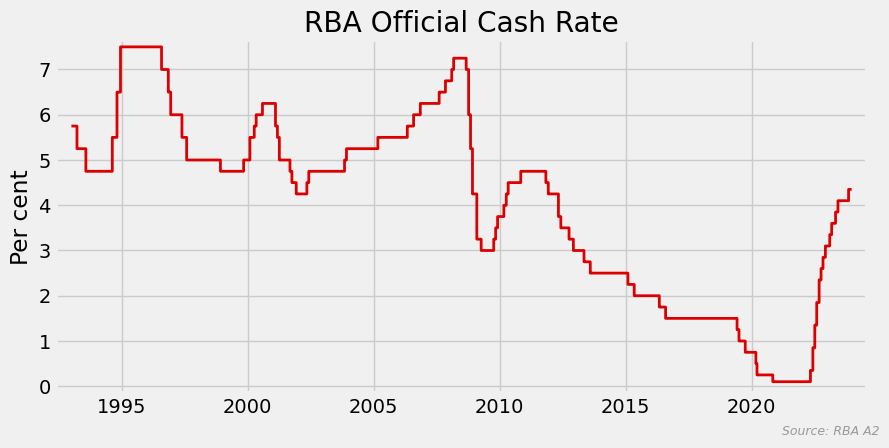

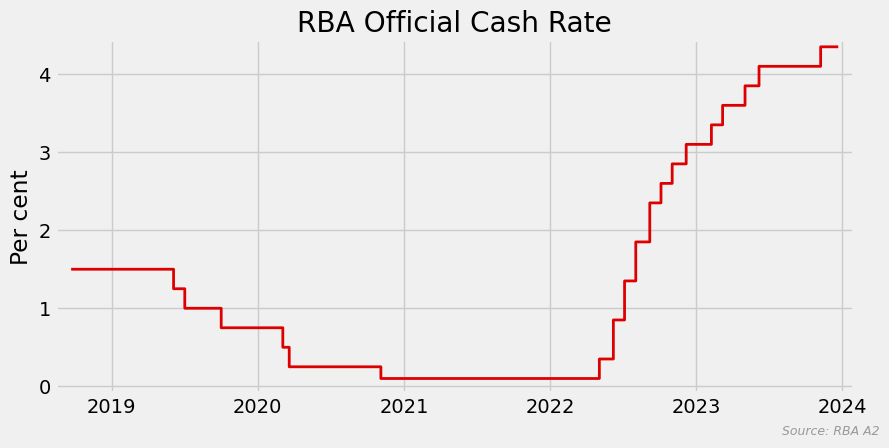

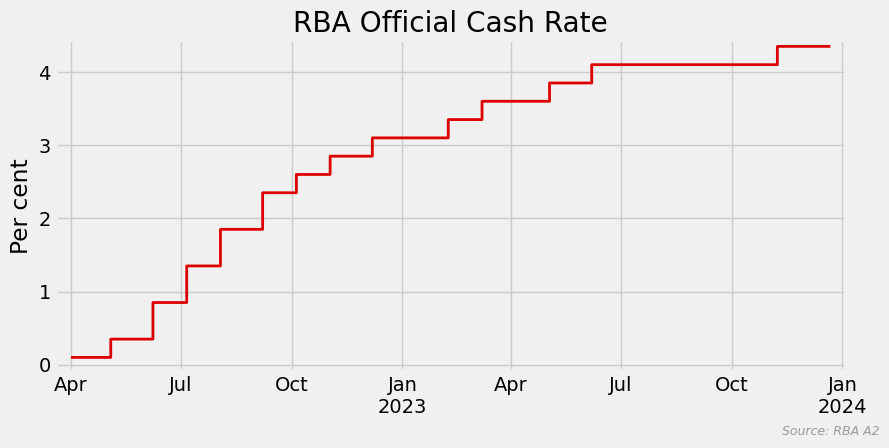

In [8]:
# extract the cash rate series
target = "New Cash Rate Target"
series_id = a2_meta[a2_meta.Title == target].index[0]
ocr_rba = a2_data[series_id].to_period(freq="D")

# remove some early target ranges
ocr_rba = ocr_rba[ocr_rba.index >= "1990-08-02"].astype(float)

# update the series to today
T = pd.Period(TODAY, freq="D")
if T > ocr_rba.index[-1]:
    last = ocr_rba.iloc[-1]
    ocr_rba[T] = last
    ocr_rba = ocr_rba.sort_index()

# plot full series and recent
ocr_rba = ocr_rba.resample("d").ffill()
line_plot(
    ocr_rba,
    starts=["1993-01-01", YEARS5, CURRENT_CYCLE],
    title="RBA Official Cash Rate",
    drawstyle="steps-post",
    ylabel="Per cent",
    zero_y=True,
    rfooter=f"{SOURCE} A2",
    show=SHOW,
)

### Highlight the monetary policy tightening cycles

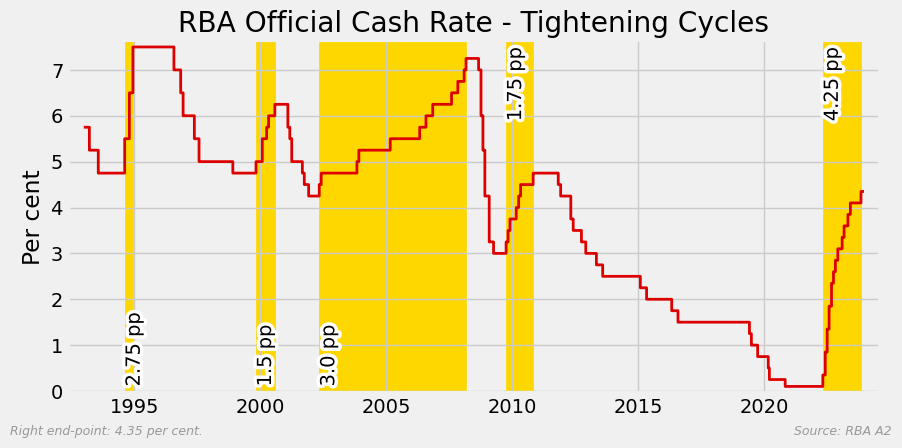

In [9]:
from_date = "1993-01-01"  # Start of RBA inflation-targeting approach
series_93 = ocr_rba[ocr_rba.index >= from_date]

ax = plot_series_highlighted(series_93)
finalise_plot(
    ax,
    title="RBA Official Cash Rate - Tightening Cycles",
    ylabel="Per cent",
    rfooter=f"{SOURCE} A2",
    lfooter=f"Right end-point: {series_93.iloc[-1]} per cent. ",
    show=SHOW,
)

## Housing Loan Payments (E13)

In [10]:
e13 = rba_data_capture.get_data("Housing Loan Payments - E13")
e13_meta, e13_data = e13 if e13 is not None else (None, None)

Source modification date: 2023-11-03 00:47:05+00:00
Retrieving data from the cache file: RBA_CACHE/29afb43a70c346a54fd8b1f5051f307f--e13hist.xlsx


In [11]:
# Note - some data is labeled monthly and some data is labeled quarterly
e13_meta.Frequency.unique()

array(['Quarterly', 'Monthly'], dtype=object)

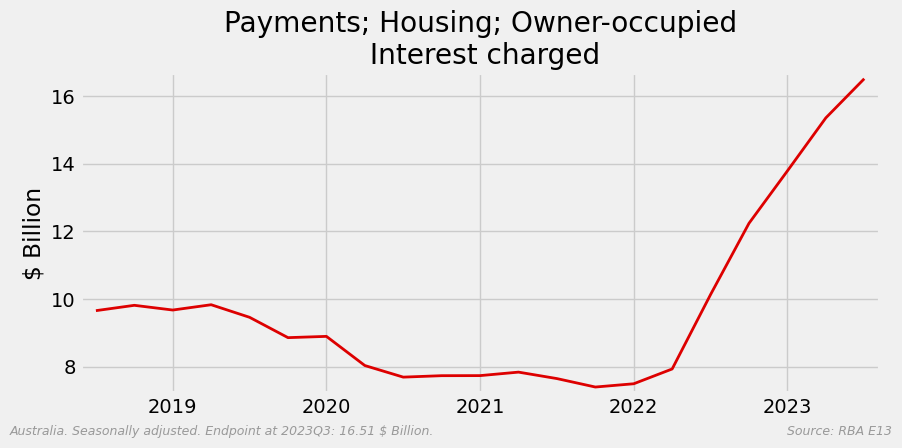

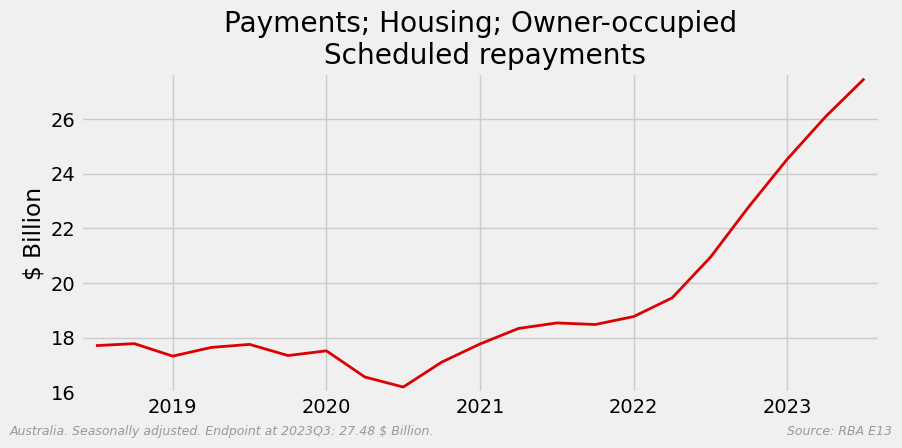

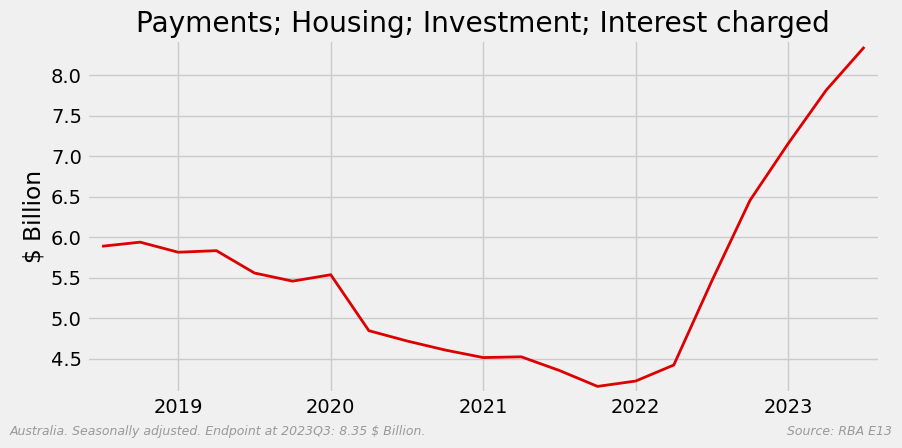

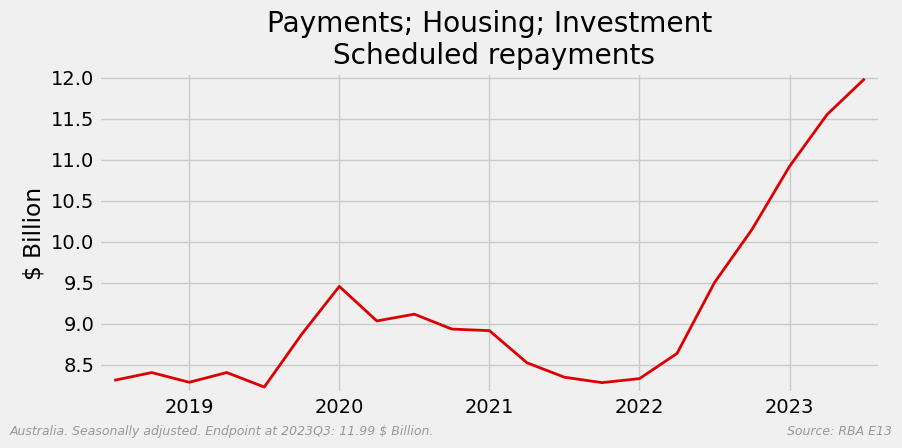

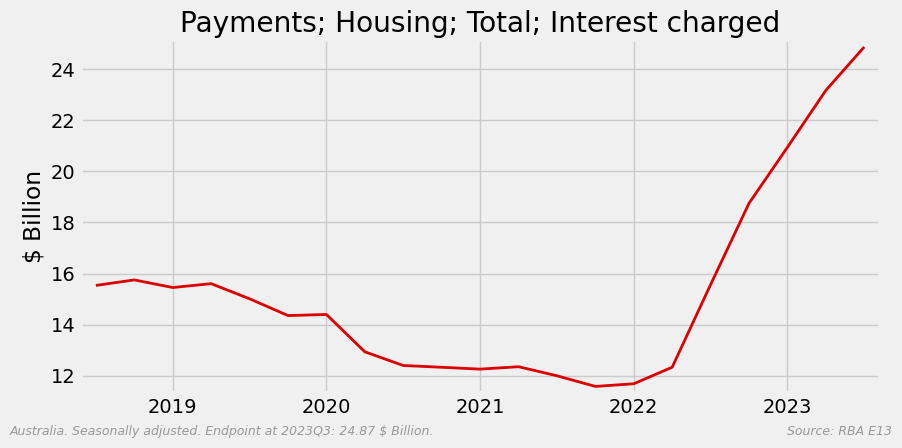

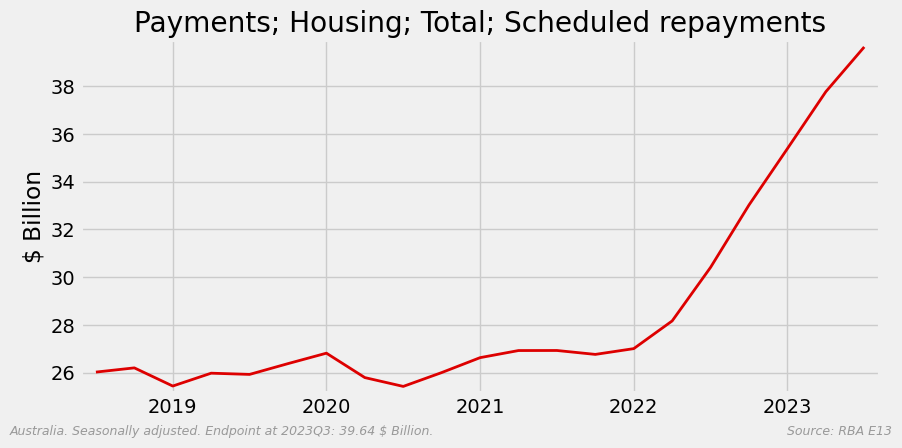

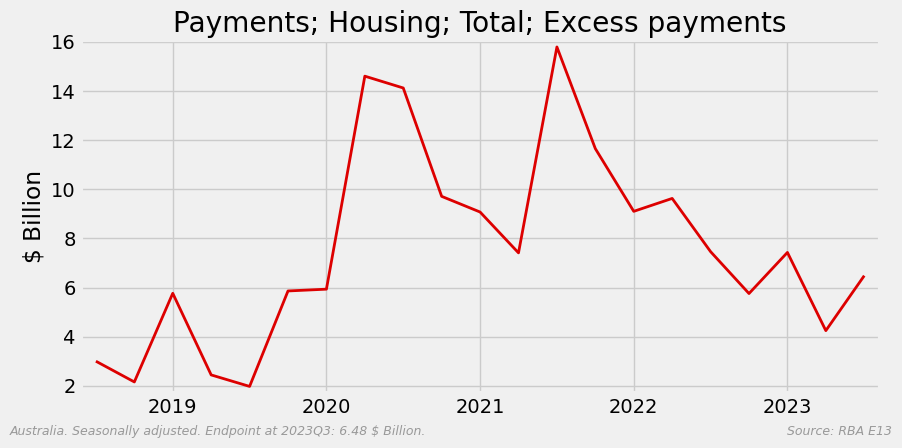

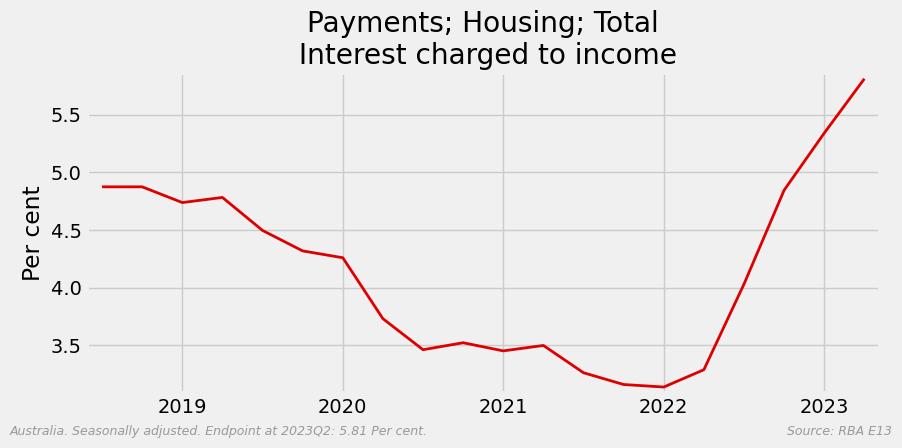

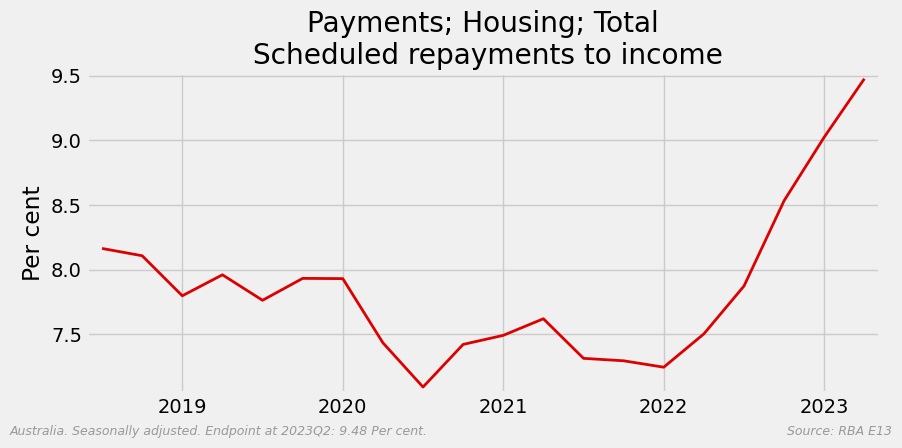

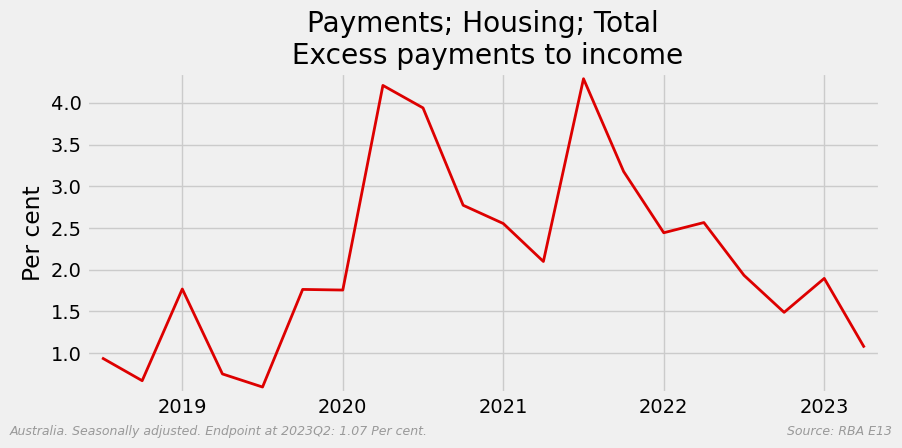

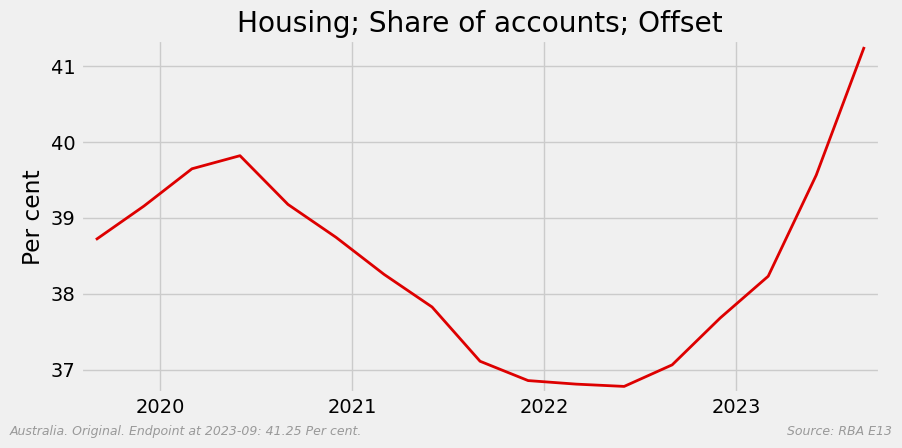

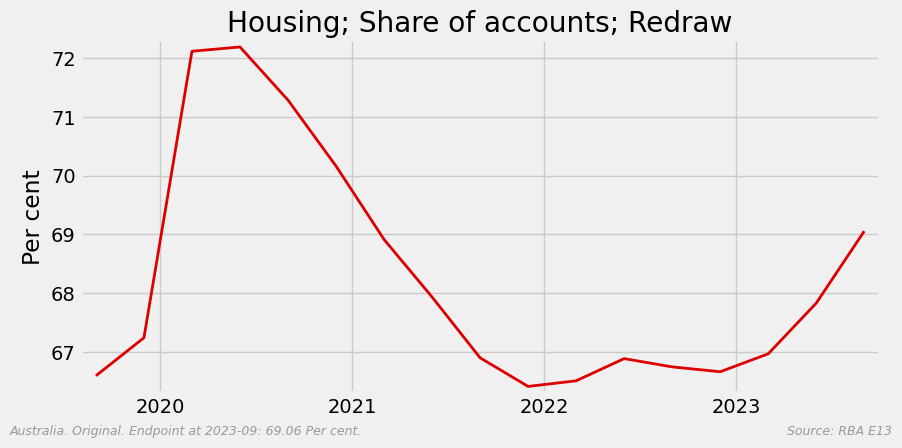

In [12]:
freqs = {"Quarterly": "Q", "Monthly": "M"}
for index, row in e13_meta.iterrows():
    title = row["Title"]
    unit = row["Units"]
    id = row["Series ID"]
    series_type = row["Type"]
    freq = freqs[row["Frequency"]]
    series = e13_data[id].astype(float).dropna().to_period(freq=freq)
    series, unit = recalibrate_series(series, unit)

    SPLIT_TITLE = 50  # characters
    if len(title) > SPLIT_TITLE:
        title = "\n".join(title.rsplit(";", 1))

    line_plot(
        series,
        starts=YEARS5,
        title=title,
        ylabel=unit,
        rfooter=f"{SOURCE} E13",
        lfooter=f"Australia. {series_type}. Endpoint at {series.index[-1]}: "
        f"{series.iloc[-1]:.02f} {unit}. ",
        show=SHOW,
    )

## Key market interest rates (F1)

In [13]:
# get the dataset
_ = rba_data_capture.get_data("Interest Rates and Yields – Money Market – Daily – F1")
f1_meta, f1_data = _ if _ is not None else (None, None)
f1_data = f1_data.to_period(freq="D")

# just to see data currency ...
f1_data.loc[f1_data.index[-3:]]

Source modification date: 2023-12-21 22:00:52+00:00
About to download and cache the latest data.
Removing old cache file.
Saving to cache: RBA_CACHE/8c1db91fee0d8c426c22e84c78607de2--f01d.xls


Series ID,FIRMMCRTD,FIRMMCCRT,FIRMMCRID,FIRMMCRIH,FIRMMCRIL,FIRMMCRIV,FIRMMCRIN,FIRMMCTRI,FIRMMBAB30D,FIRMMBAB90D,FIRMMBAB180D,FIRMMOIS1D,FIRMMOIS3D,FIRMMOIS6D,FIRMMTN1D,FIRMMTN3D,FIRMMTN6D
F1 INTEREST RATES AND YIELDS – MONEY MARKET,,,,,,,,,,,,,,,,,
2023-12-20,4.35,NaN,4.32,4.32,4.32,710,5,130.764441,4.3038,4.3553,4.4551,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-21,4.35,NaN,4.32,4.32,4.32,2054,13,130.779918,4.3081,4.3633,4.4586,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.795397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


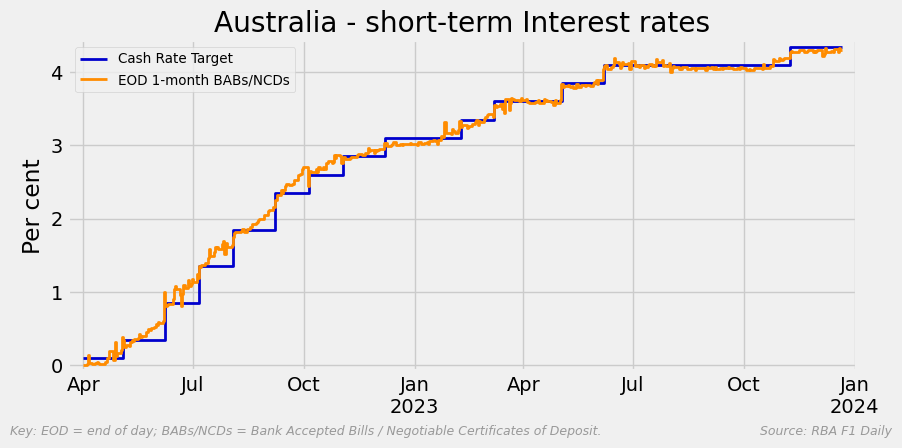

In [14]:
# get the specific data we want, for the very recent past
wanted = [
    "Cash Rate Target",
    #'Interbank Overnight Cash Rate',
    "EOD 1-month BABs/NCDs",
    # '1-month OIS',  # discontinued December 2022
    # '1-month Treasury Note',
]
series_ids = [f1_meta[f1_meta.Title == x].index[0] for x in wanted]
plotable_data = (
    f1_data[series_ids]
    .rename({old: neu for old, neu in zip(series_ids, wanted)}, axis=1)
    .dropna(how="all", axis=1)
    .dropna(how="all", axis=0)
    .ffill()
)

# And plot
title = "Australia - short-term Interest rates"
line_plot(
    plotable_data,
    starts=CURRENT_CYCLE,
    title=title,
    drawstyle="steps-post",
    ylabel="Per cent",
    rfooter=f"{SOURCE} F1 Daily",
    lfooter="Key: EOD = end of day; "
    "BABs/NCDs = Bank Accepted Bills / Negotiable Certificates of Deposit.",
    show=SHOW,
)

## Australian Government Bonds

### Utility functions

In [15]:
def get_bonds(meta, data):
    bond_yield = meta[
        meta.Title.str.contains("Australian|Commonwealth")
        & meta.Title.str.contains("year")
    ]
    bond_yield_labels = bond_yield.Title.str.replace(
        "Australian Government ", ""
    ).str.replace("Commonwealth Government ", "")
    bond_yield_data = data[bond_yield_labels.index]
    bond_yield_data.columns = bond_yield_labels

    return bond_yield_data

In [16]:
def plot_yields(data, period, table, show=SHOW):
    # plot full series and recent
    title = "Capital Market Yields - Australian Government Bonds"

    line_plot(
        data,
        starts=[None, MONTHS6],
        tags=f"{table}-{period}",
        width=1,
        drawstyle="steps-post",
        title=title,
        ylabel="Per cent per annum",
        rfooter=f"{SOURCE} {table} {period}",
        show=show,
    )

In [17]:
def inversion_plot(data, lo, hi, show=SHOW):
    t_lo = f"{lo} year bond"
    t_hi = f"{hi} year bond"

    inversions = bonds_daily[t_hi] - bonds_daily[t_lo]
    inversions = -inversions.where(inversions < 0, other=0)
    line_plot(
        inversions,
        starts=[None, MONTHS6],
        title=f"Capital Market Yield Inversions [({hi}-year - {lo}-year) * -1]",
        ylabel="% points difference",
        rfooter=f"{SOURCE} F2 Daily",
        lfooter=f"Australian Government Bonds. Data up to {data.index[-1]}. ",
        show=show,
    )

In [18]:
# This is a rough first approximation - but needs work ...


def bond_price_calculator(
    face_value: float,
    years_to_maturity: float,
    yield_rate: float,
    coupon_rate: float,
    coupons_per_year: int,
    verbose: bool = False,
) -> float | None:
    """Calculate a bond price.
    Bond price is the present value of all future cash flows
    (coupons + face_value).
    Arguments
    - face_value - float - face-value of the bond
    - years_to_maturity - float - years to maturity
    - yield_rate - float - annual yield or market rate as a
      percentage (aka yield to maturity or YTM) (variable)
    - coupon_rate - float - percent annual coupon rate as
      a percentage (fixed when the bond is first issued)
    - coupons_per_year - int - number of coupon payments per year
    - verbose - bool - print out each step in the calculation.

    Note: If the coupon_rate is the same as the yield_rate then
    the bond is selling at par (at its face_value). if the
    coupon_rate is less than the yield_rate, then the bond is
    selling at a discount. If a bond's coupon_rate is more than
    its yield_rate, then the bond is selling at a premium."""

    if verbose:
        print(f"Face value of the bond: ${face_value:0.2f}.")
        print(f"Yield to maturity rate: {yield_rate}%.")
        print(
            f"Coupon rate: {coupon_rate}%, "
            f"paid {coupons_per_year} times annually, "
            f"for {years_to_maturity} years."
        )

    # no payment beyond term ...
    if years_to_maturity <= 0:
        return None

    # convert annual percent to periodic rate
    periodic_rate = yield_rate / (coupons_per_year * 100.0)
    if verbose:
        print(f"Periodic rate: {periodic_rate}")

    # number of coupon payments that will be made.
    n = math.ceil(years_to_maturity * coupons_per_year)
    if verbose:
        print(f"Number of coupon payments: {n}")

    if n > 0:
        # current value of periodic coupon payments
        C = (face_value * (coupon_rate / 100.0)) / coupons_per_year
        if verbose:
            print(f"Coupon face value: ${C:0.2f}")

        # present value of all coupon payments
        sum_C = C * (1 - (1 + periodic_rate) ** -n) / periodic_rate

    else:
        sum_C = 0.0  # no (further) coupon payments
    if verbose:
        print(f"Present value of all (remaining) coupons: ${sum_C:0.2f}")

    # present value of the bond par-value
    F = face_value / (1 + periodic_rate) ** n
    if verbose:
        print(f"Present value of the final bond payment: ${F:0.2f}")

    if verbose:
        print(f"Present value of the bond: ${sum_C + F:0.2f}")
    return sum_C + F

### Get the data

In [19]:
# get the dataset
_ = rba_data_capture.get_data("Capital Market Yields – Government Bonds – Daily – F2")
f2_meta, f2_data = _ if _ is not None else (None, None)
f2_data = f2_data.to_period(freq="D")

Source modification date: 2023-12-21 07:06:34+00:00
Retrieving data from the cache file: RBA_CACHE/566a22db8c9683dce3f0298f43d8ffde--f02d.xls


In [20]:
f2_data.head()

Series ID,FCMYGBAG2D,FCMYGBAG3D,FCMYGBAG5D,FCMYGBAG10D,FCMYGBAGID,FCMYGBNT3D,FCMYGBNT5D,FCMYGBNT10D
F2 CAPITAL MARKET YIELDS – GOVERNMENT BONDS,,,,,,,,
2021-01-04,0.08,0.1,0.34,0.98,-0.793786,0.185,0.45,1.235
2021-01-05,0.07,0.1,0.335,0.95,-0.81363,0.185,0.44,1.205
2021-01-06,0.07,0.105,0.37,1.03,-0.743179,0.195,0.47,1.28
2021-01-07,0.075,0.105,0.38,1.05,-0.771829,0.19,0.485,1.305
2021-01-08,0.075,0.105,0.4,1.09,-0.72696,0.195,0.5,1.345


### Mark to market

The subsequent market value of a $100 10-year bond baught at the COVID low yield minima.

In [21]:
OPEN_COVID_PEAK = "2020-07-01"
CLOSE_COVID_PEAK = "2021-06-30"
bonds_daily = get_bonds(f2_meta, f2_data)
PERIOD = 10
yields = bonds_daily[f"{PERIOD} year bond"]
minima_rate = yields[
    (yields.index >= OPEN_COVID_PEAK) & (yields.index <= CLOSE_COVID_PEAK)
].min()
minima_date = str(yields[yields == minima_rate].index[-1])

yields = yields[yields.index >= minima_date]
years = 10 - (
    yields.index.to_timestamp().to_series() - pd.Timestamp(minima_date)
) / pd.Timedelta(days=365.242199)
years.index = yields.index
results = pd.DataFrame([yields, years], index=["Yield", "Years"]).T
results["Value"] = np.nan

PAR = 100

for index, row in results.iterrows():
    row["Value"] = bond_price_calculator(
        face_value=PAR,
        years_to_maturity=row["Years"],
        yield_rate=row["Yield"],
        coupon_rate=minima_rate,
        coupons_per_year=2,
        verbose=False,
    )

line_plot(
    results["Value"],
    title="Hypothetical AG Bond Marked to Market",
    ylabel="Bond Value $",
    rfooter=f"{SOURCE} F2 Daily",
    lfooter=f"Assume a ${PAR} {PERIOD}-year Australian Government Bond bought at par on {minima_date}. "
    f"Coupon rate: {minima_rate}% per year. ",
    show=SHOW,
)
results.tail()

,Yield,Years,Value
F2 CAPITAL MARKET YIELDS – GOVERNMENT BONDS,,,
2023-12-15,4.140,7.059485,NaN
2023-12-18,4.055,7.051272,NaN
2023-12-19,4.110,7.048534,NaN
2023-12-20,4.045,7.045796,NaN
2023-12-21,4.015,7.043058,NaN


### Australian Government Bonds - daily rates (F2)

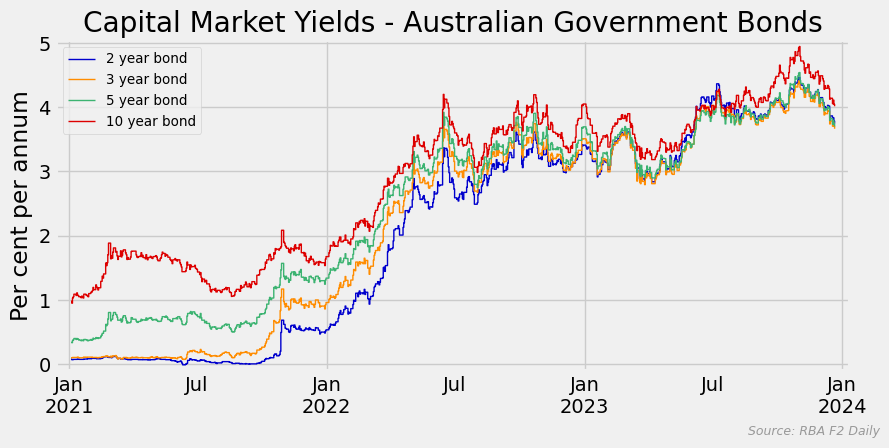

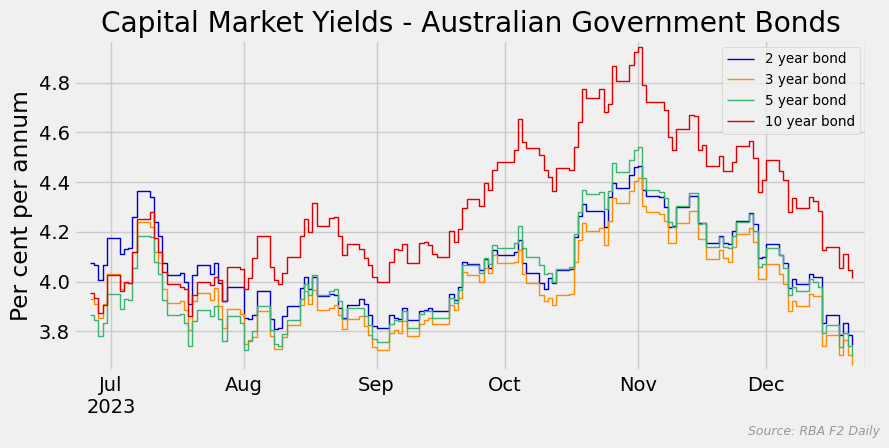

In [22]:
bonds_daily = get_bonds(f2_meta, f2_data)
plot_yields(bonds_daily, "Daily", "F2")

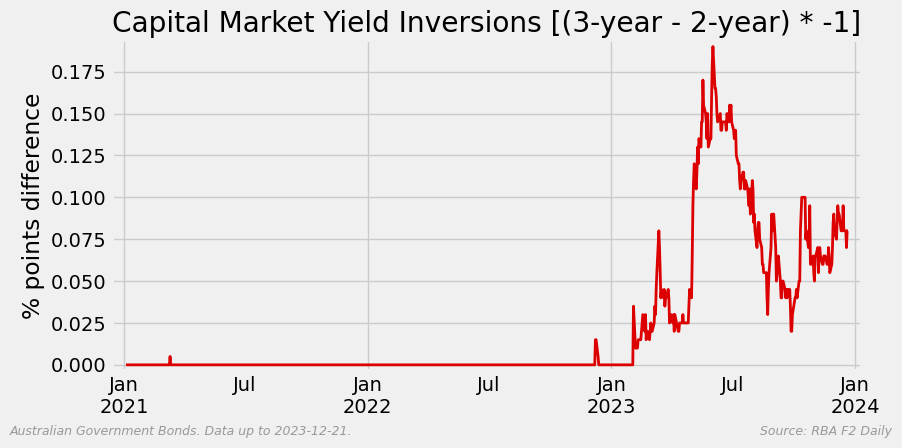

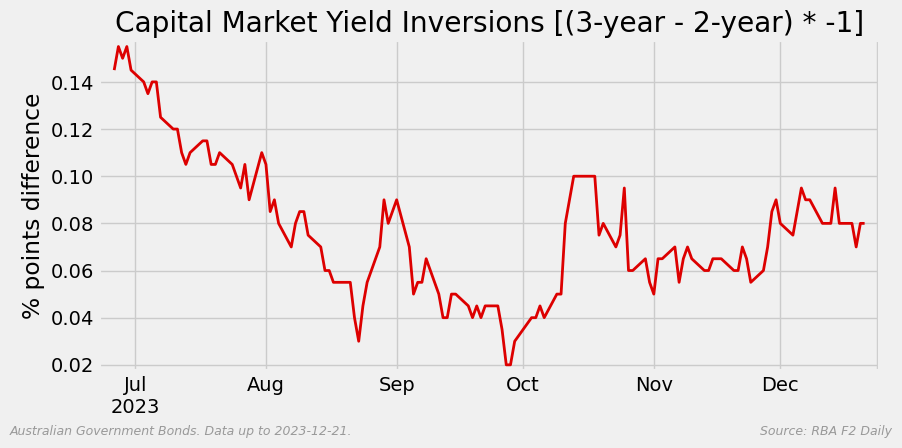

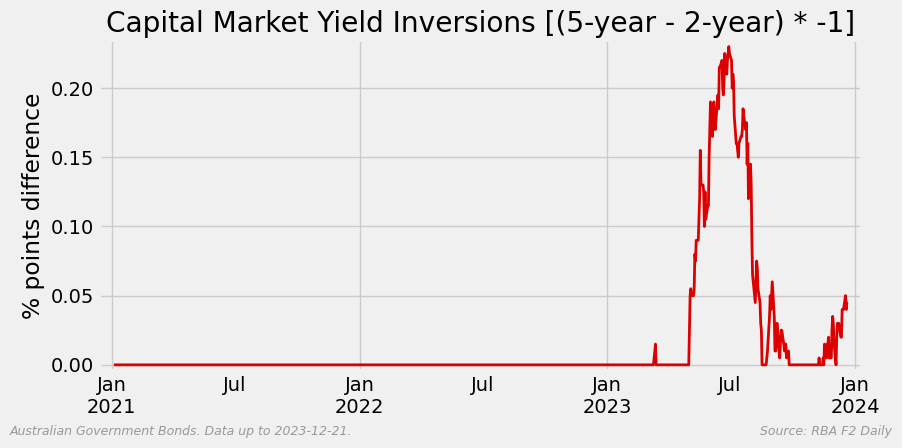

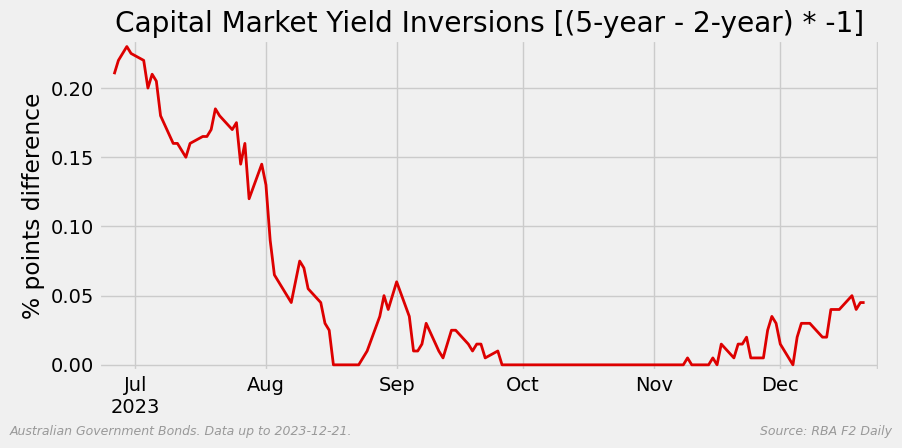

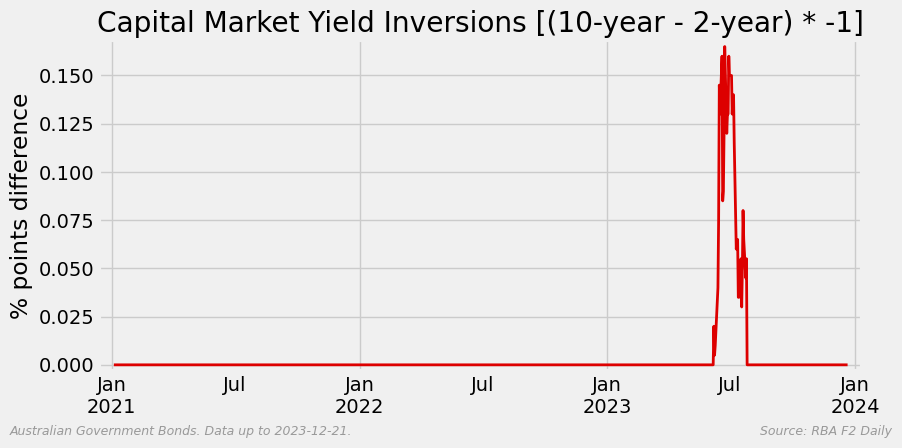

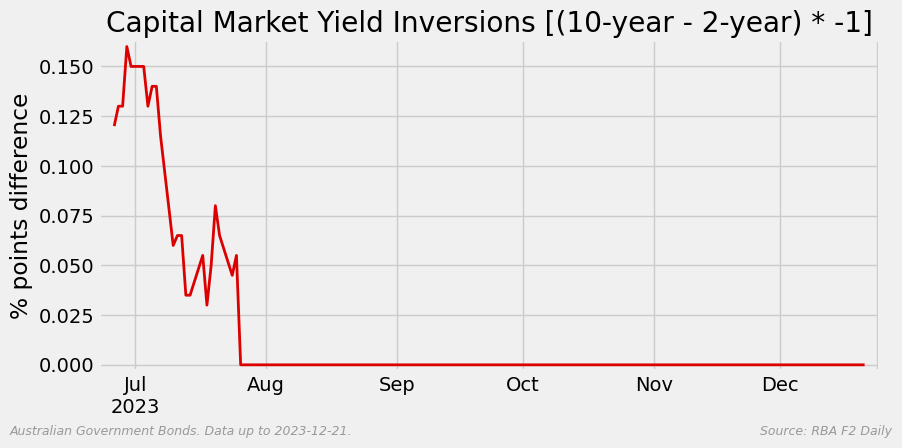

In [23]:
inversion_plot(f2_data, 2, 3)
inversion_plot(f2_data, 2, 5)
inversion_plot(f2_data, 2, 10)

## Growth in credit aggregates (D1)

In [24]:
data_label = "Growth in Selected Financial Aggregates – D1"
_ = rba_data_capture.get_data(data_label)
d1_meta, d1_data = _ if _ is not None else (None, None)
d1_data = d1_data.to_period(freq="M")
print_last_date(d1_data)

Source modification date: 2023-12-22 00:12:23+00:00
About to download and cache the latest data.
Removing old cache file.
Saving to cache: RBA_CACHE/6db07bfe9b2daee1ef6cc78d5f5839a9--d01hist.xlsx
Last date 2023-11


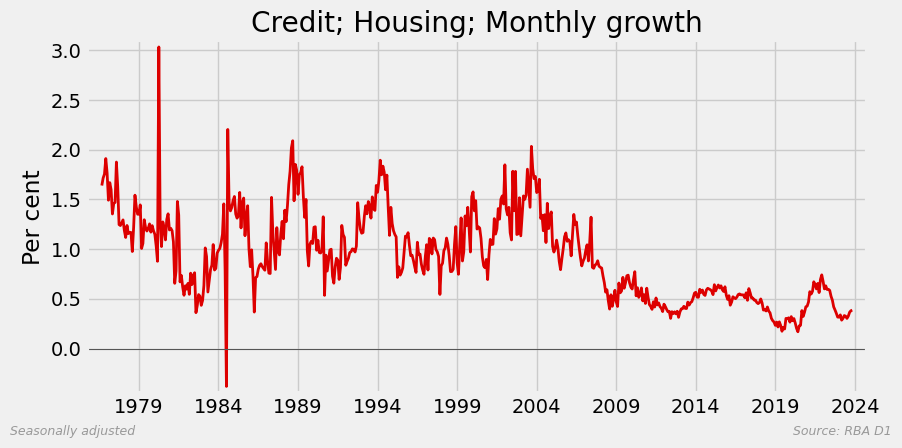

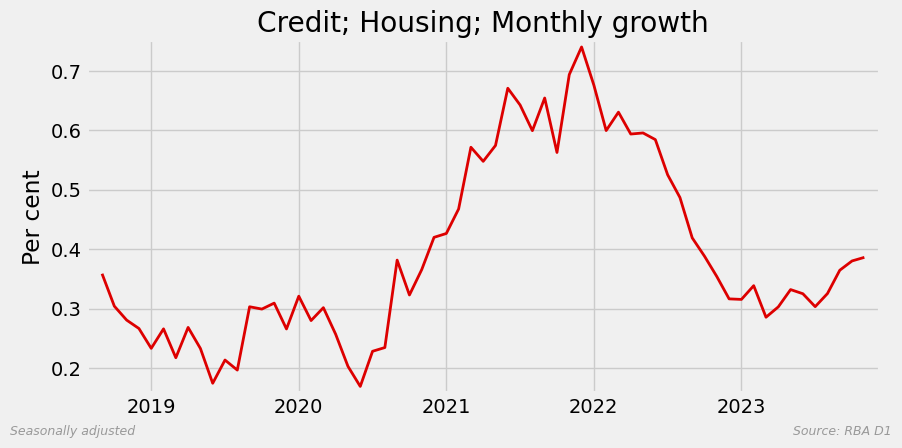

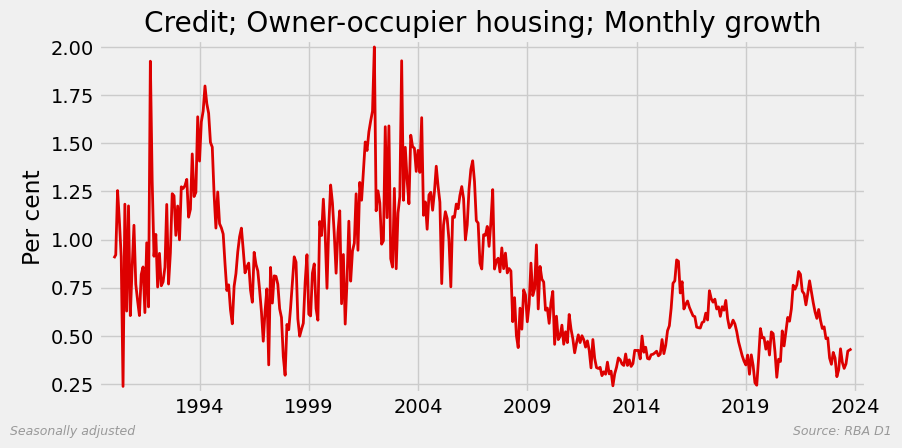

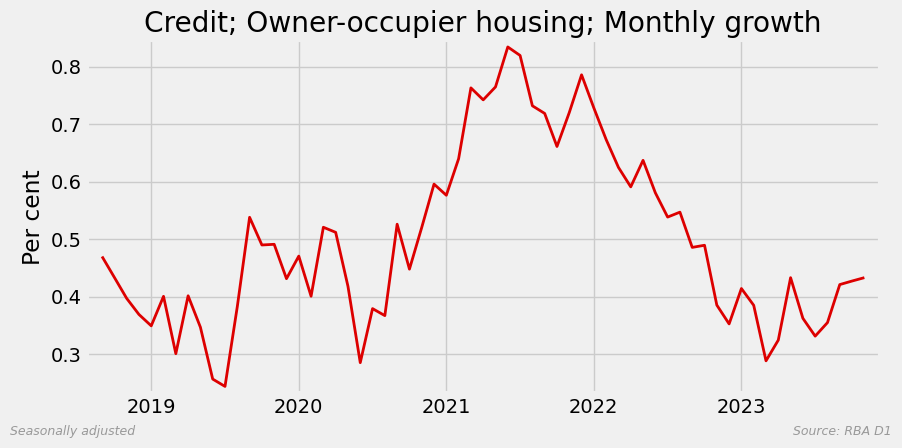

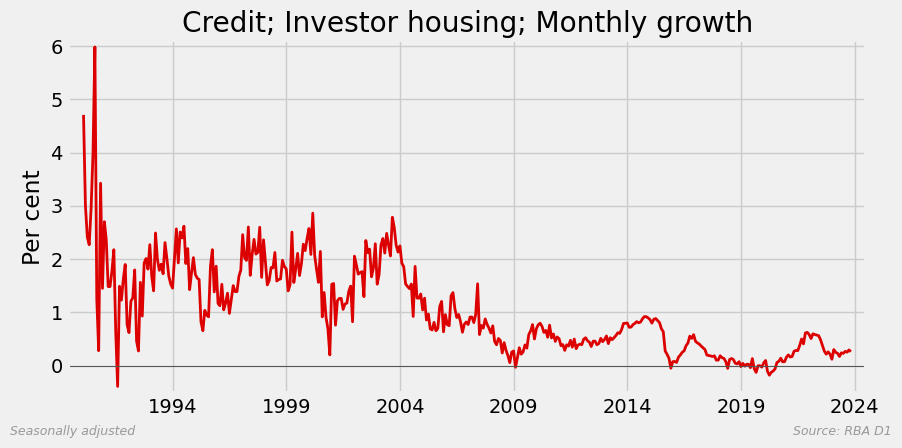

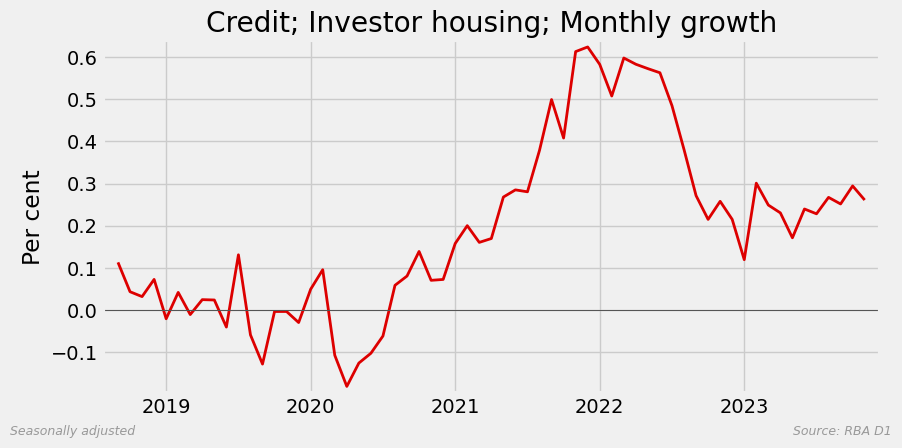

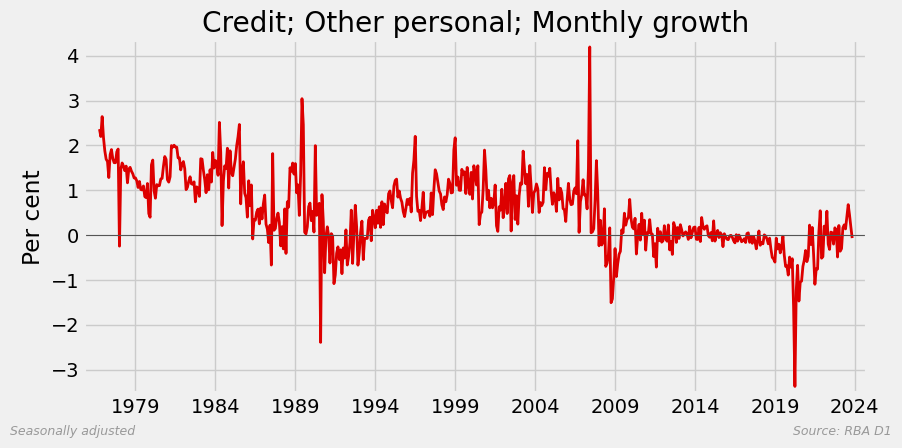

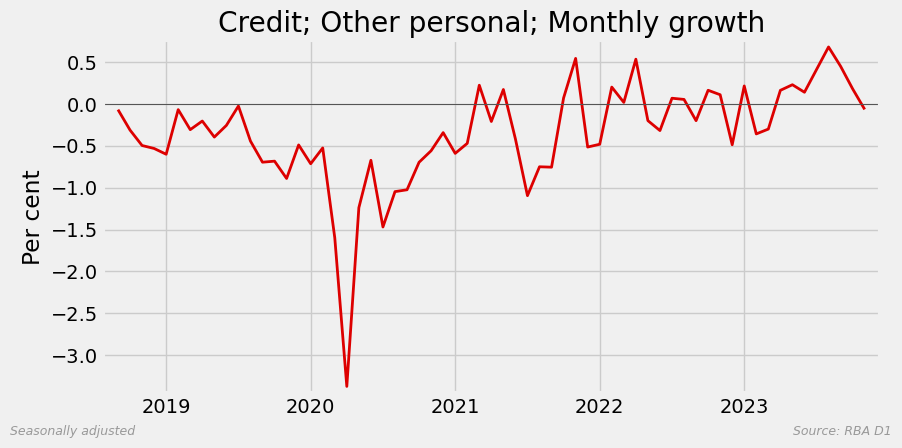

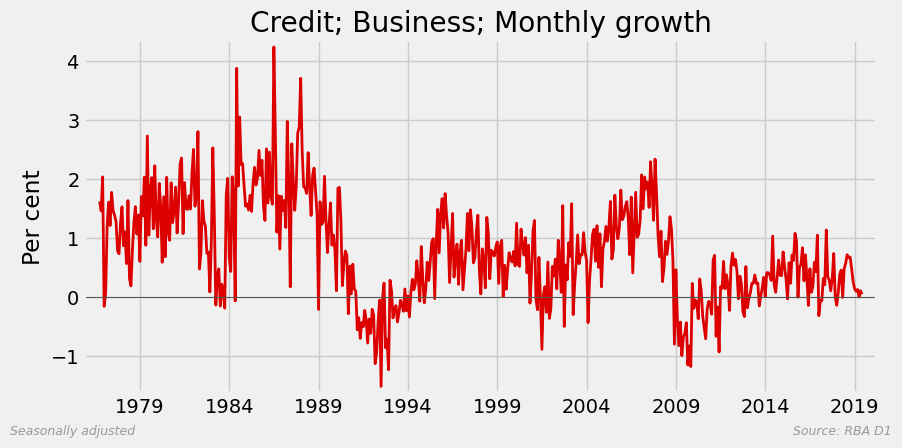

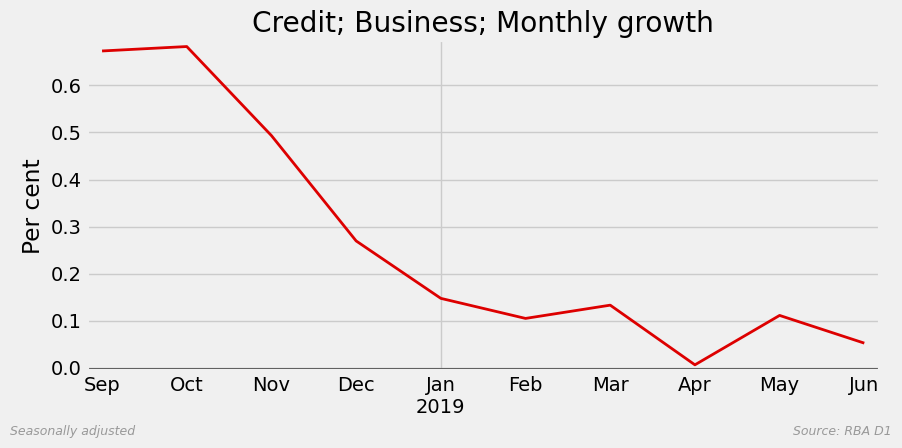

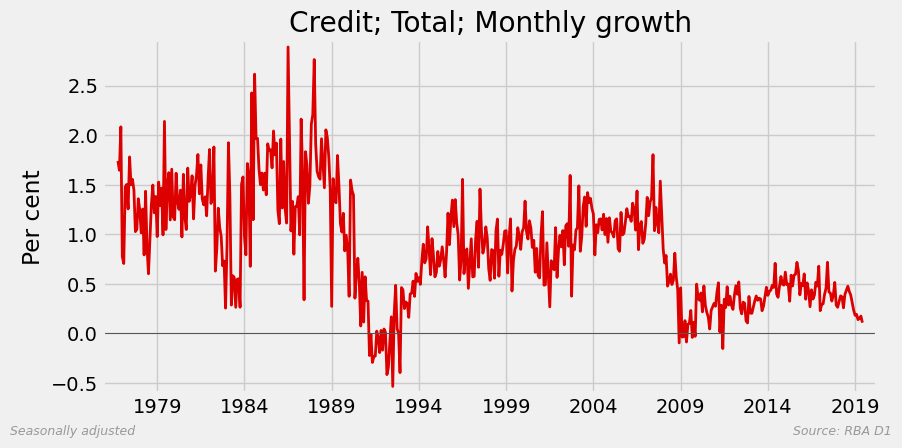

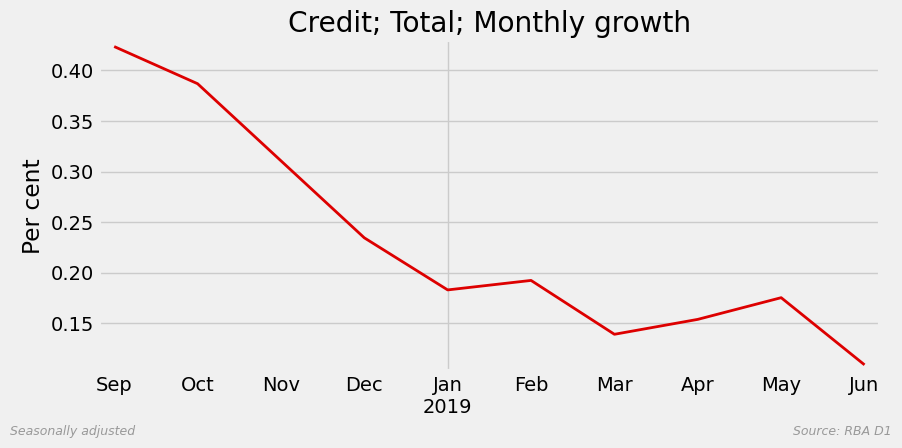

In [25]:
chart_set = [
    "Credit; Housing; Monthly growth",
    "Credit; Owner-occupier housing; Monthly growth",
    "Credit; Investor housing; Monthly growth",
    "Credit; Other personal; Monthly growth",
    "Credit; Business; Monthly growth",
    "Credit; Total; Monthly growth",
]

for label in chart_set:
    name = d1_meta[d1_meta.Title == label].index[0]
    type = d1_meta[d1_meta.Title == label].Type.iloc[0]
    series = d1_data[name]

    line_plot(
        series,
        starts=[None, YEARS5],
        y0=True,
        title=label,
        ylabel="Per cent",
        rfooter=f"{SOURCE} D1",
        lfooter=type,
        show=SHOW,
    )

## Money supply and the velocity of money (D3)

According to the Quantity Theory of Money:

$$ MV=PT $$

Where ($M$) is money supply, ($V$) is the velocity of circulation (the number of times 
money changes hands), ($P$) is the average price level, and ($T$) is the volume of transactions of goods and services. Of note: $PT$ is the same as nominal GDP. Therefore:

$$V=\frac{nGDP}{M}$$


### Money supply

In [26]:
# Get DataFrame for the M1 and M3 money supply
_ = rba_data_capture.get_data("Monetary Aggregates – D3")
d3_meta, d3_data = _ if _ is not None else (None, None)
d3_data = d3_data.to_period(freq="M")

Source modification date: 2023-12-22 00:12:23+00:00
About to download and cache the latest data.
Removing old cache file.
Saving to cache: RBA_CACHE/3bb444ebe3112807ffaf2dbf157edeb6--d03hist.xlsx


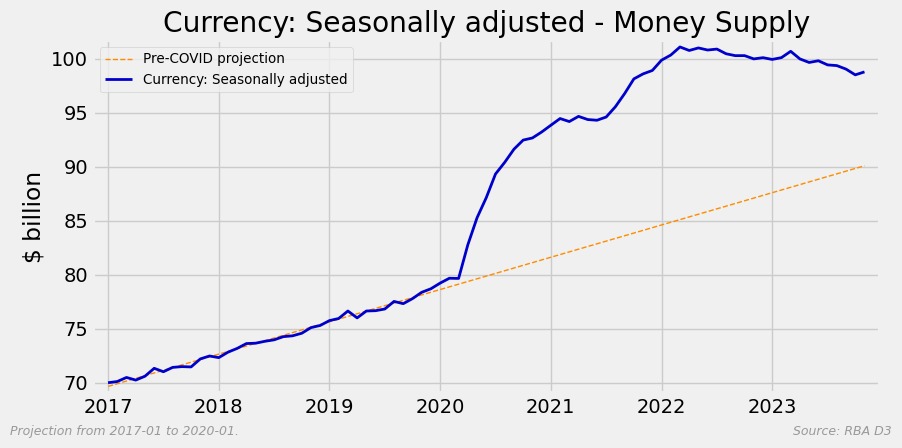

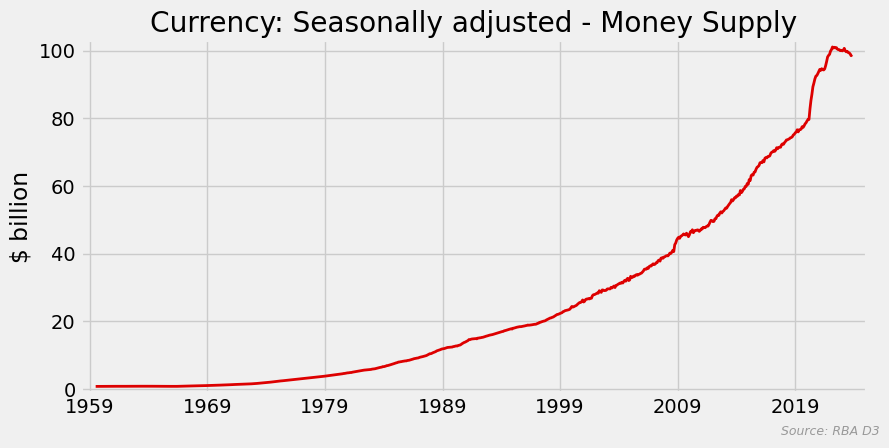

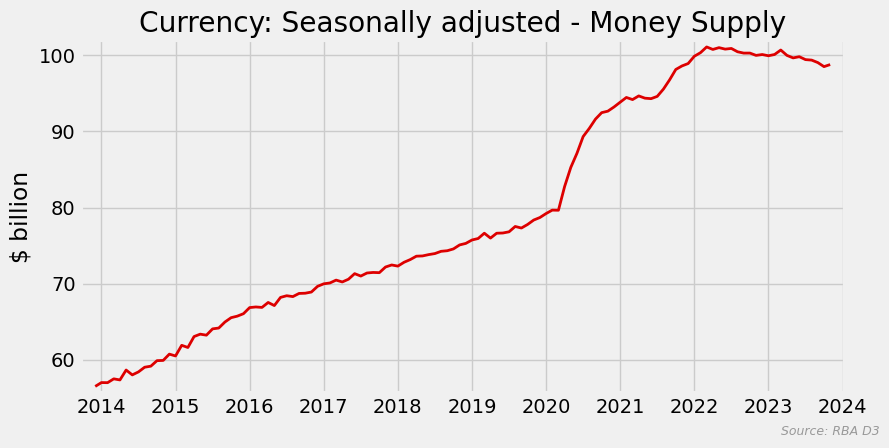

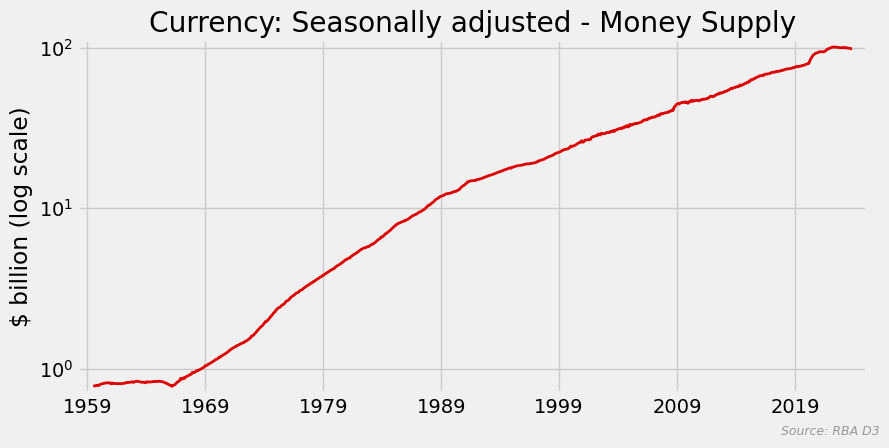

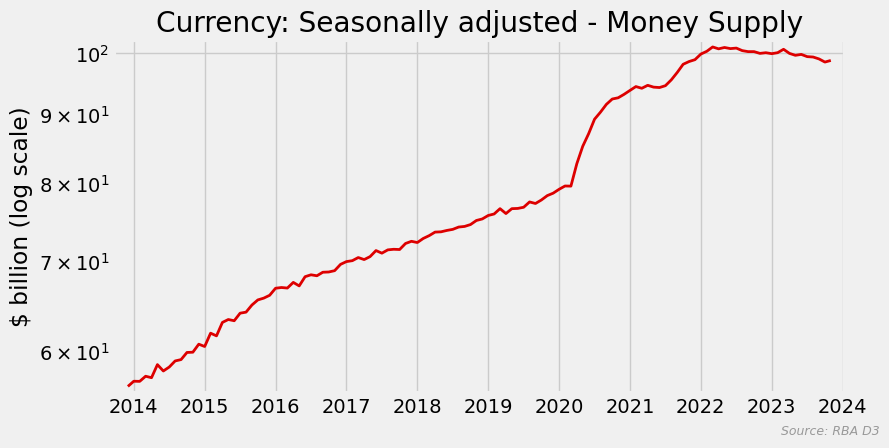

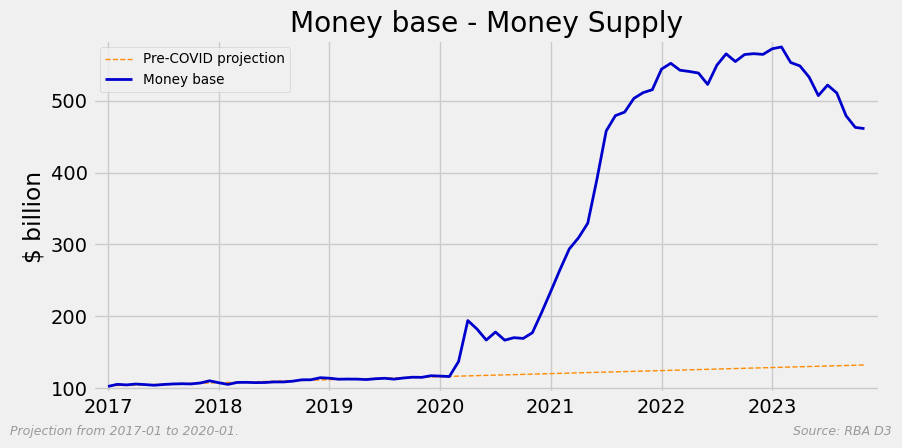

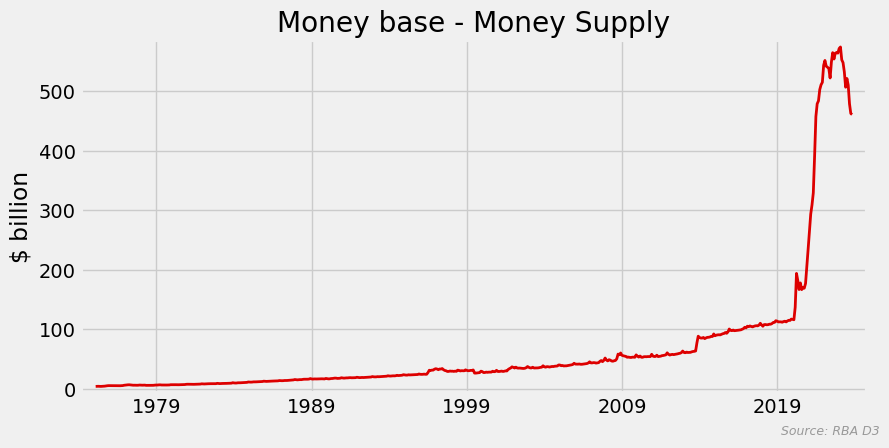

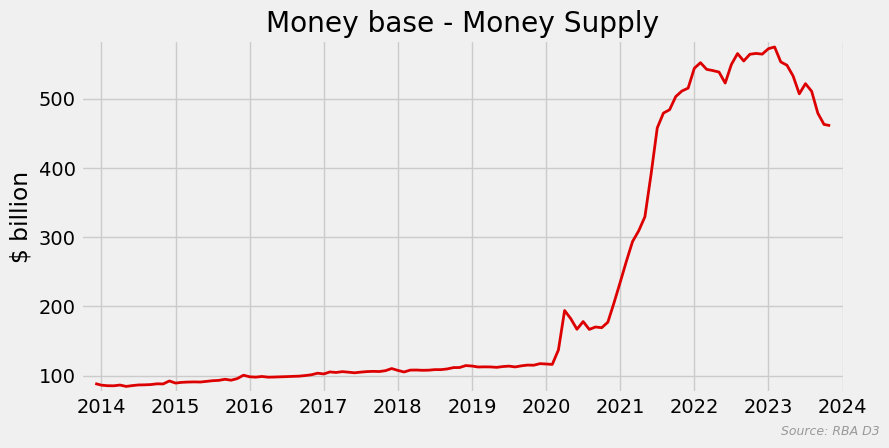

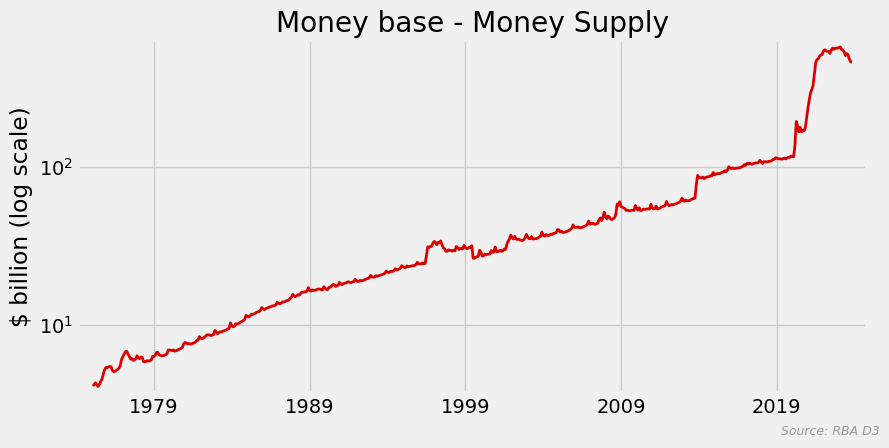

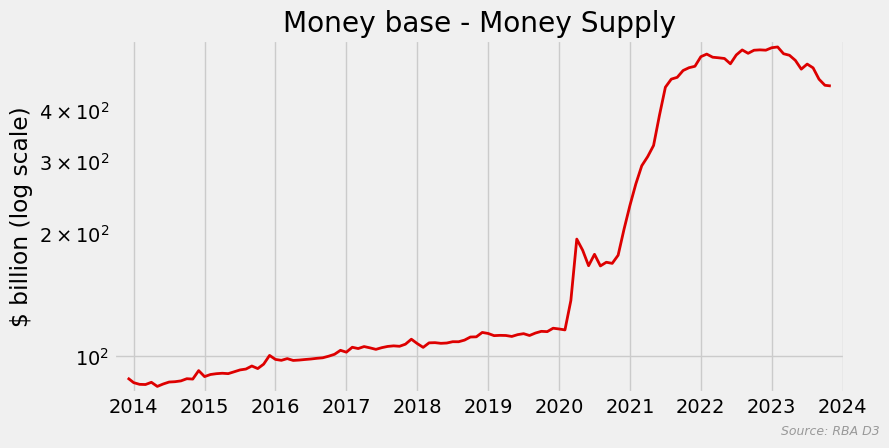

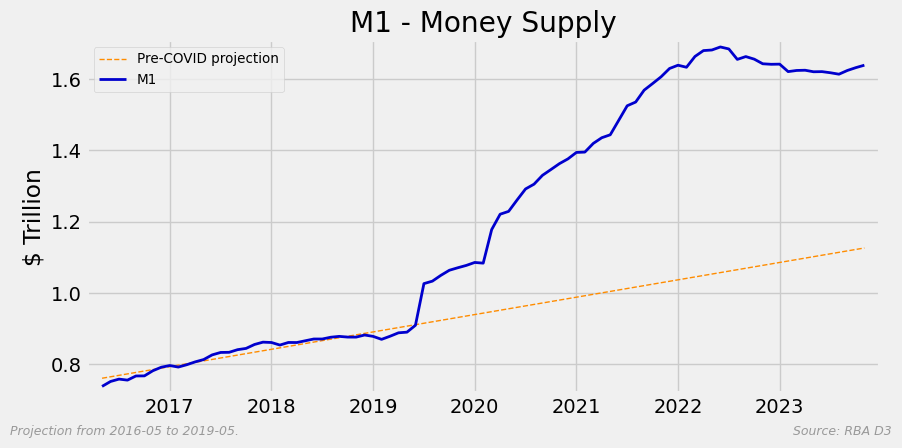

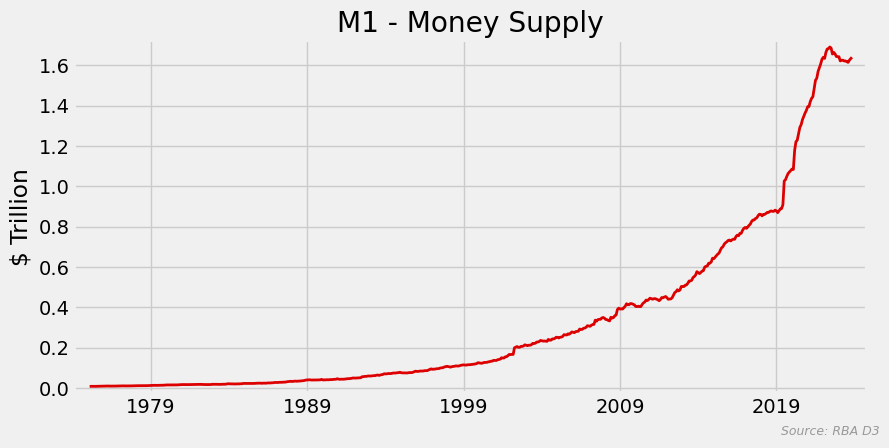

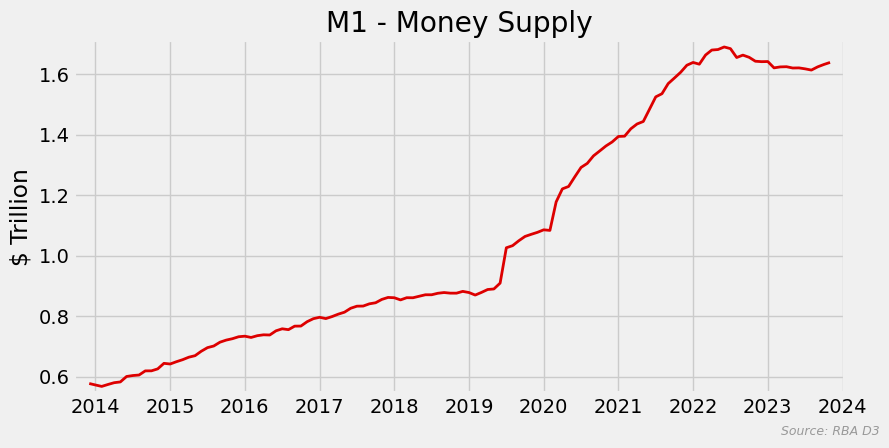

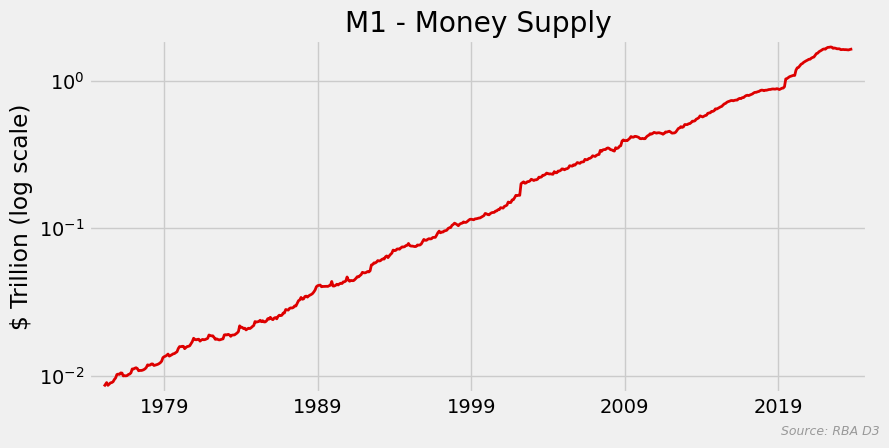

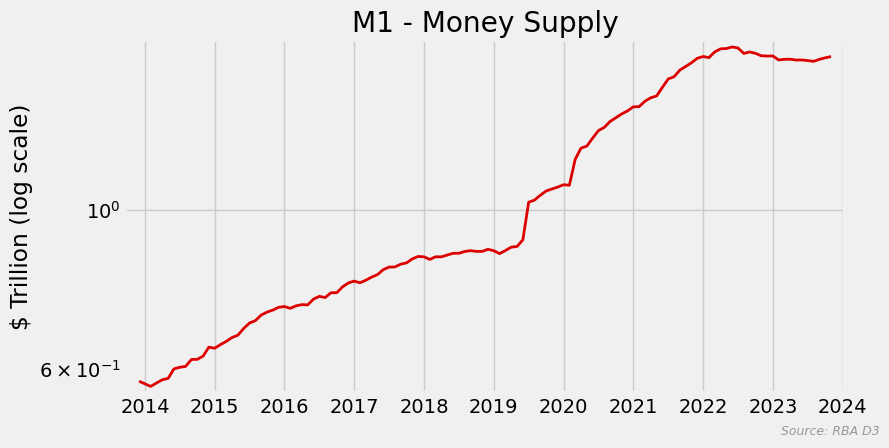

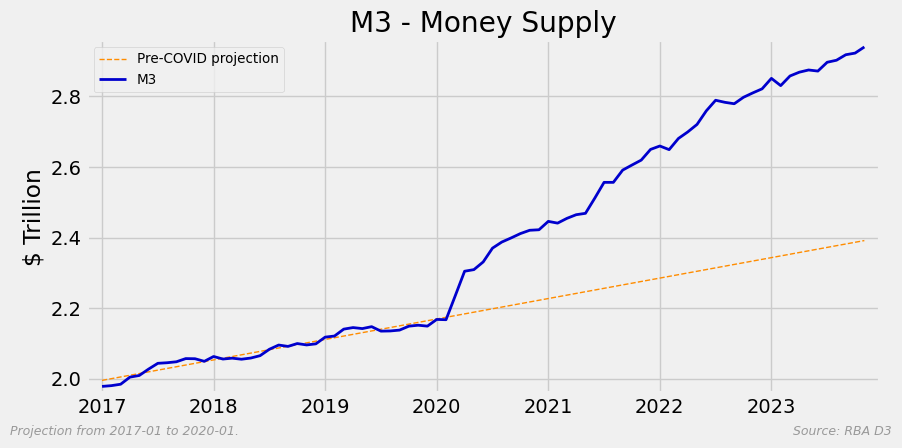

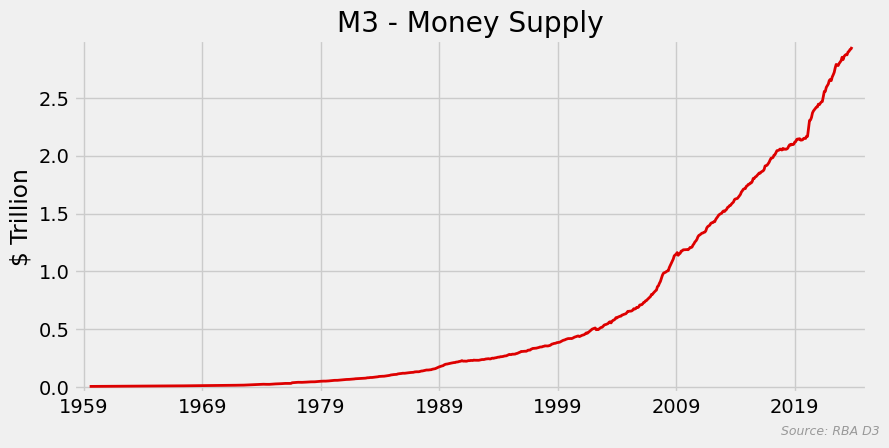

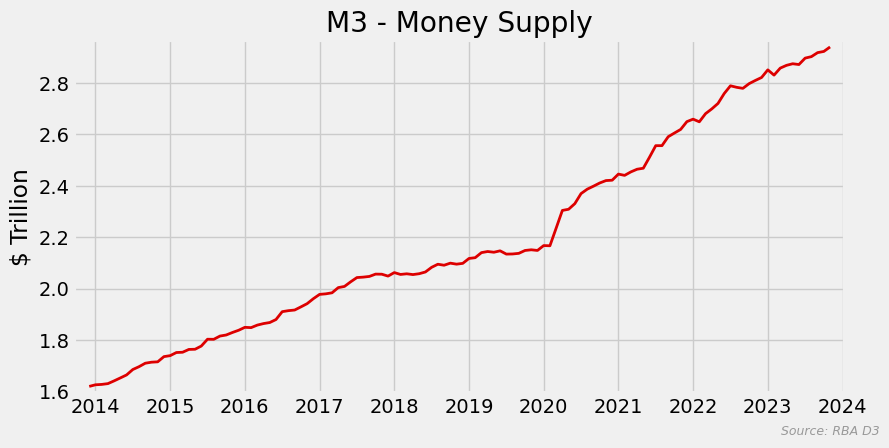

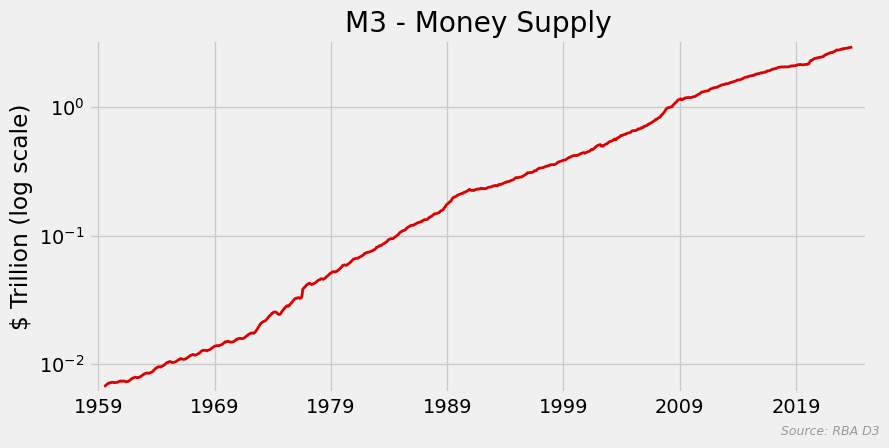

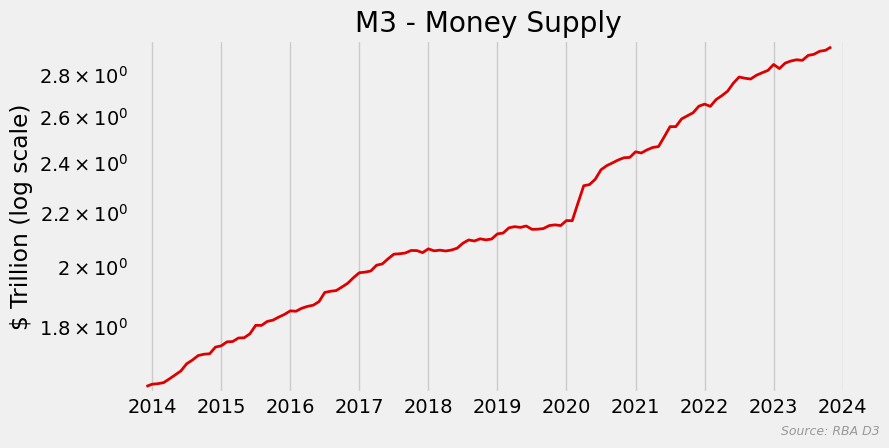

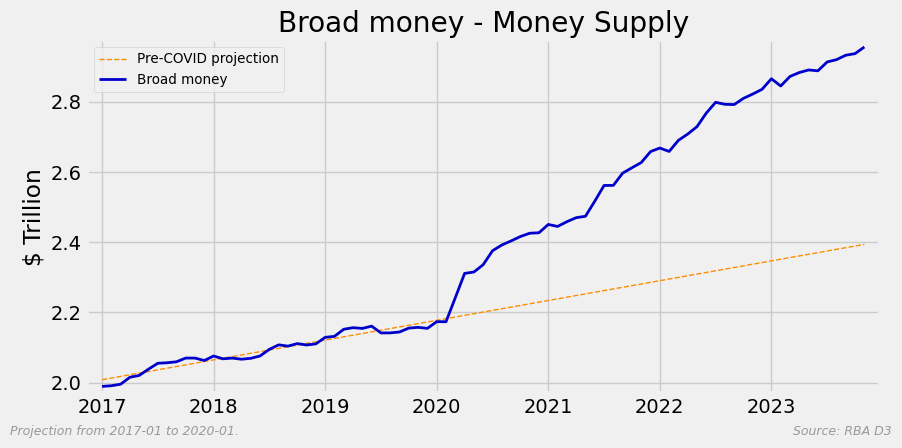

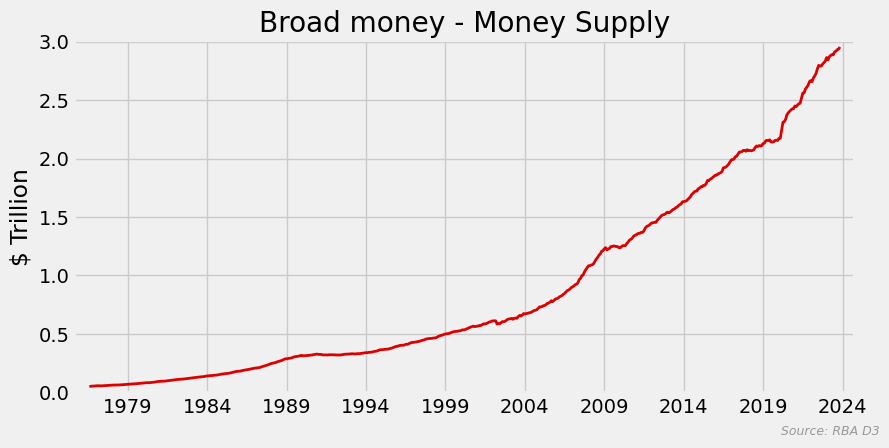

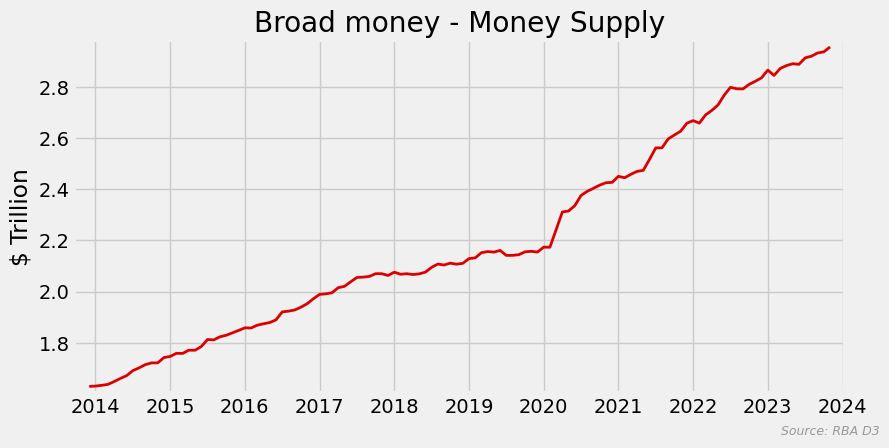

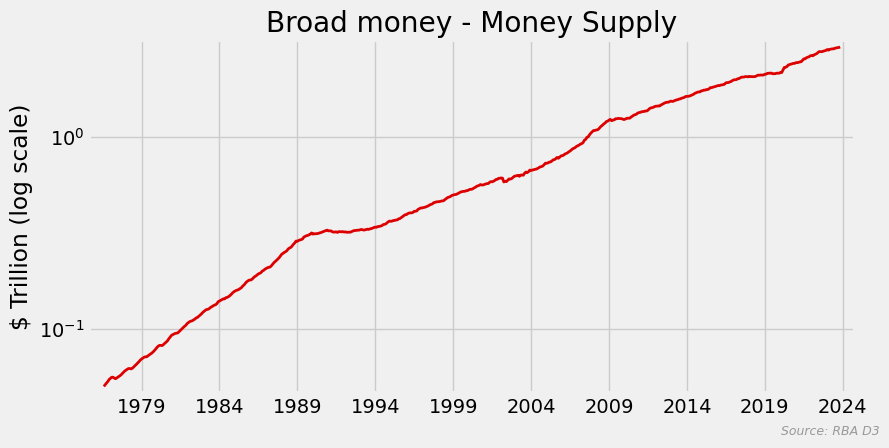

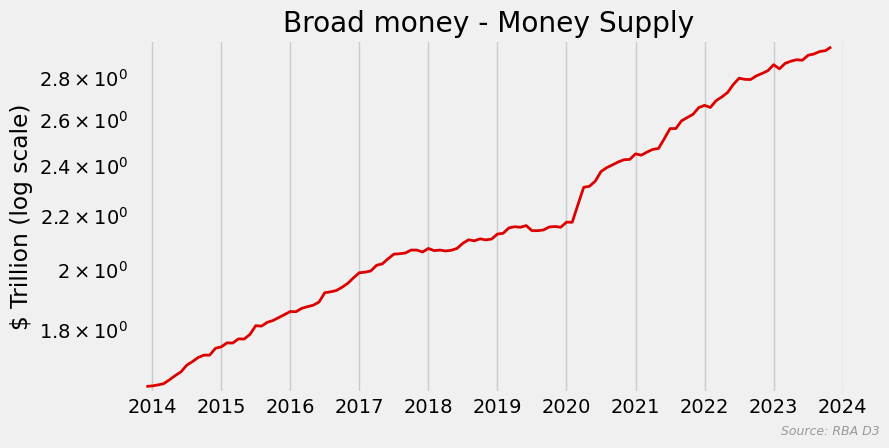

In [27]:
# plot Money Supply
to_get = ["Currency: Seasonally adjusted", "Money base", "M1", "M3", "Broad money"]
gotten = {t: d3_data[d3_meta[d3_meta.Title == t].index[0]] for t in to_get}
m_units = {t: d3_meta[d3_meta["Title"] == t].Units.iloc[0] for t in to_get}

for title, series in gotten.items():
    series = series.dropna().astype(float)
    series, m_unit = recalibrate_series(series, m_units[title])
    series.name = title
    chart_title = f"{title} - Money Supply"

    aux_kwargs = {}
    aux_kwargs["start_r"], aux_kwargs["end_r"] = (
        ("2016-05-01", "2019-05-01") if title == "M1" else ("2017-01-01", "2020-01-01")
    )

    plot_covid_recovery(
        series,
        **aux_kwargs,
        title=chart_title,
        tags="COVID",
        ylabel=m_unit,
        rfooter=f"{SOURCE} D3",
        show=SHOW,
    )

    line_plot(
        series,
        starts=[None, TEN_YEARS],
        title=chart_title,
        ylabel=m_unit,
        rfooter=f"{SOURCE} D3",
        show=SHOW,
    )

    line_plot(
        series,
        starts=[None, TEN_YEARS],
        title=chart_title,
        ylabel=f"{m_unit} (log scale)",
        rfooter=f"{SOURCE} D3",
        yscale="log",
        show=SHOW,
    )

### Nominal GDP

In [28]:
if False:
    # get nominal GDP from the ABS National Accounts
    catalogue_id = "5206"
    abs_dict = get_abs_meta_and_data(catalogue_id)
    source, _, META_DATA = get_fs_constants(catalogue_id)
    meta = abs_dict[META_DATA]

    table = "3"  # GDP expenditure in current prices
    data = abs_dict[table]

    series_type = "Seasonally Adjusted"
    data_item = "GROSS DOMESTIC PRODUCT ;"
    selected = meta[
        (meta.Table == table)
        & (meta["Series Type"] == series_type)
        & meta["Data Item Description"].str.contains(data_item)
    ]
    assert len(selected) == 1
    units = selected.Unit.iloc[0]
    series_id = selected["Series ID"].iloc[0]
    yearly_nom_gdp = (
        data[series_id].rolling(4).sum().dropna()
    )  # sum to annual nominal GDP
    yearly_nom_gdp, units = recalibrate_series(yearly_nom_gdp, units)

### Velocity of money

In [29]:
# still to do

## Watermark

In [30]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Dec 22 2023 12:19:30

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.18.1

numpy     : 1.26.2
matplotlib: 3.8.2
pandas    : 2.1.4

Watermark: 2.4.3



In [31]:
print("Done")

Done
